In [1]:
import spacy
import pandas as pd
import json
import matplotlib.pyplot as plt

import random
import typer
from pathlib import Path
from spacy.tokens import DocBin, Doc
from spacy.training.example import Example

# make the factory work
from rel_pipe import make_relation_extractor, score_relations

# make the config work
from rel_model import create_relation_model, create_classification_layer, create_instances, create_tensors

import custom_functions

In [2]:
# --> Loading Models
ner = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/NER trained on nightly/ner-cb1-159-15-12")
rel = spacy.load("/Users/leonidas/OneDrive - Universität St.Gallen/General/02-Coding/03-Models/Relations/0-trained-on-djx/2021-09-01/training/model-best")

In [9]:
# --> Load test data and name annotated data "golds"
test_data = "/Users/leonidas/ReciParse_Scripts/06_annotated_data_analysis/results/assets/test.spacy"
doc_bin = DocBin(store_user_data=True).from_disk(test_data)
golds = doc_bin.get_docs(rel.vocab)

## Create Examples

In [10]:
def create_examples(predict_ents=True, print_details=False, predict_rels=True):
    for gold in golds:
        # ner prediction
        if predict_ents == True:
            pred = ner(gold.text)
        else:
            pred = Doc(rel.vocab,
                       words=[t.text for t in gold],
                       spaces=[t.whitespace_ for t in gold],)
            pred.ents = gold.ents
            
        # rel prediction
        if predict_rels == True:
            for name, proc in rel.pipeline:
                pred = proc(pred)
        # Create pair of pred and anno & Append pair to list
        examples.append(Example(pred, gold))

In [11]:
# reassign golds!
examples = []
# predict_ents=True, print_details=False, predict_rels=True
create_examples(True, False, True)

ℹ Detected 185 total instances.
ℹ Detected 107 total instances.
ℹ Detected 89 total instances.
ℹ Detected 208 total instances.
ℹ Detected 208 total instances.
ℹ Detected 192 total instances.
ℹ Detected 164 total instances.
ℹ Detected 106 total instances.
ℹ Detected 248 total instances.
ℹ Detected 81 total instances.
ℹ Detected 65 total instances.
ℹ Detected 86 total instances.
ℹ Detected 90 total instances.
ℹ Detected 119 total instances.
ℹ Detected 135 total instances.
ℹ Detected 161 total instances.
ℹ Detected 141 total instances.
ℹ Detected 169 total instances.
ℹ Detected 131 total instances.
ℹ Detected 29 total instances.
ℹ Detected 97 total instances.
ℹ Detected 122 total instances.
ℹ Detected 183 total instances.
ℹ Detected 74 total instances.
ℹ Detected 136 total instances.
ℹ Detected 102 total instances.
ℹ Detected 141 total instances.
ℹ Detected 91 total instances.
ℹ Detected 65 total instances.
ℹ Detected 142 total instances.
ℹ Detected 125 total instances.
ℹ Detected 82 tota

## Overall Score

In [14]:
from spacy.scorer import PRFScore

def score_relations(examples, threshold):
    """Score a batch of examples."""
    micro_prf = PRFScore()
    ec = 0
    c = 0

    for example in examples:
        gold = example.reference._.rel
        pred = example.predicted._.rel
        for key, pred_dict in pred.items():
            try:
                gold_labels = [k for (k, v) in gold[key].items() if v == 1.0]
                for k, v in pred_dict.items():
                    if v >= threshold:
                        if k in gold_labels:
                            micro_prf.tp += 1
                        else:
                            micro_prf.fp += 1
                    else:
                        if k in gold_labels:
                            micro_prf.fn += 1
            except KeyError:
                if max(pred_dict.values()) >= threshold:
                    ec+=1
                    micro_prf.fp += 1
            c+=1                
    return {
        "error_count": ec,
        "rel_count": c,
        "key_error_rate": ec/c,
        "rel_micro_p": micro_prf.precision,
        "rel_micro_r": micro_prf.recall,
        "rel_micro_f": micro_prf.fscore,
    }

In [15]:
thresholds = [n*0.01 for n in range(0,100)]
labels = ['Arg0Z','Arg0Tool','Arg1Z','Arg1Tool','ArgAttr','ArgTemp','ArgDauer','ArgZeitp','ArgPräp']
# labels = ['Arg0Z','Arg0Tool']

In [16]:
# threshold = 0.5
f_overall_th = []
for th in thresholds:
    f_overall_th.append((th,score_relations(examples, th)["rel_micro_f"]))

In [31]:
df_f[df_f["f"]==max(df_f["f"])]["th"]

49    0.49
Name: th, dtype: float64

(0.0, 1.0)

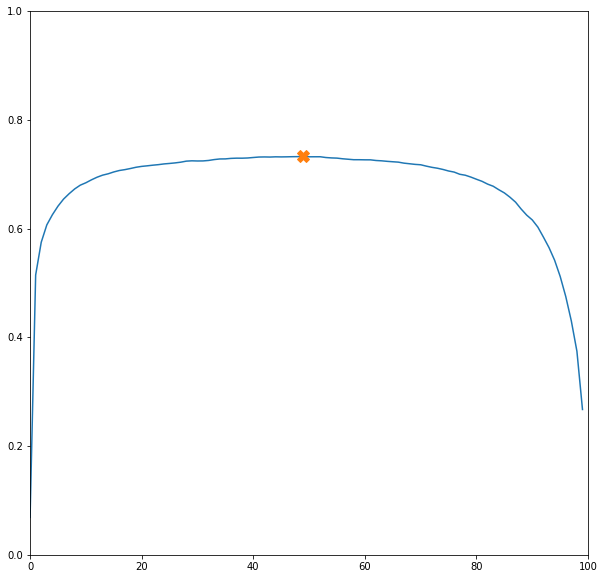

In [53]:
df_f = pd.DataFrame(f_overall_th, columns=["th","f"])
best_th = float(df_f[df_f["f"]==max(df_f["f"])]["th"])
plt.figure(figsize=(10,10))
df_f["f"].plot()
plt.plot(best_th*100,df_f["f"][int(best_th*100)], "X", label="Best Threshold", markersize=12)
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,1])

In [61]:
temp = score_relations(examples, best_th)
pd.DataFrame(temp, index=["measures"])

,error_count,rel_count,key_error_rate,rel_micro_p,rel_micro_r,rel_micro_f
measures,58,15113,0.003838,0.706473,0.761825,0.733106


In [62]:
labels = ['Arg0Z','Arg0Tool','Arg1Z','Arg1Tool','ArgAttr','ArgTemp','ArgDauer','ArgZeitp','ArgPräp']
def score_relations_ind(examples, threshold, label):
    """Score a batch of examples."""
    ec = 0
    c = 0
    micro_prf = PRFScore()
    for example in examples:
        gold = example.reference._.rel
        pred = example.predicted._.rel
        for key, pred_dict in pred.items():
            try:
                gold_labels = [k for (k, v) in gold[key].items() if v == 1.0]
                for k, v in pred_dict.items():
                    if k == label: # filter only one type of label
                        if v >= threshold:
                            if k in gold_labels:
                                micro_prf.tp += 1
                            else:
                                micro_prf.fp += 1
                        else:
                            if k in gold_labels:
                                micro_prf.fn += 1
            except KeyError: ### was ist mit dem threshold und der max prob?
                if max(pred_dict, key=pred_dict.get) == label:
                    if max(pred_dict.values()) >= threshold:
                        ec+=1
                        micro_prf.fp += 1
            if max(pred_dict, key=pred_dict.get) == label:
                if max(pred_dict.values()) >= threshold:
                    c+=1
    return [label,micro_prf.precision,micro_prf.recall,micro_prf.fscore,micro_prf.tp,micro_prf.fp,micro_prf.fn, ec, c, ec/c]
    return {
        "label": label,
        "error_count": ec,
        "rel_count": c,
        "key_error_rate": ec/c,
        "rel_micro_p": micro_prf.precision,
        "rel_micro_r": micro_prf.recall,
        "rel_micro_f": micro_prf.fscore,
    }

In [63]:
df_ind = pd.DataFrame([score_relations_ind(examples, best_th, l) for l in labels],columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"])
df_ind

,label,p,r,f,tp,fp,fn,ec,c,er
0,Arg0Z,0.671802,0.699562,0.685401,1439,703,618,20,2136,0.009363
1,Arg0Tool,0.631579,0.666667,0.648649,24,14,12,0,37,0.000000
2,Arg1Z,0.791148,0.800000,0.795549,572,151,143,10,718,0.013928
3,Arg1Tool,0.747212,0.948113,0.835759,201,68,11,3,269,0.011152
4,ArgAttr,0.677207,0.813291,0.739037,514,245,118,11,759,0.014493
5,ArgTemp,0.850746,0.904762,0.876923,57,10,6,1,66,0.015152
6,ArgDauer,0.754310,0.956284,0.843373,175,57,8,4,231,0.017316
7,ArgZeitp,0.740741,0.824742,0.780488,160,56,34,2,216,0.009259
8,ArgPräp,0.705075,0.727016,0.715877,514,215,193,7,727,0.009629


In [64]:
# build and return dataframe with thresholds for one label
def prf_th(examples, thresholds, label):
    prf_list = []
    for th in thresholds:
        prf_list.append(score_relations_ind(examples, th, label))
    df_prf_th = pd.DataFrame(prf_list, columns=["label","p","r","f","tp","fp","fn","ec", "c", "er"],index=thresholds)
    return df_prf_th

# Plot recall and decision against each other
def plot_pr_curve(df,thresholds,label):
    precision = df["p"]
    recall = df["r"]
    # plot the roc curve for the model
    plt.plot(recall, precision, label=label)
    # axis labels

# Plot all labels into one figure
def plot_pr_all(thresholds,labels):
    plt.figure(figsize=(10,10))
    for label in labels:
        df_prf_th = prf_th(examples,thresholds,label)
        plot_pr_curve(df_prf_th,thresholds,label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=3)
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    plt.show()

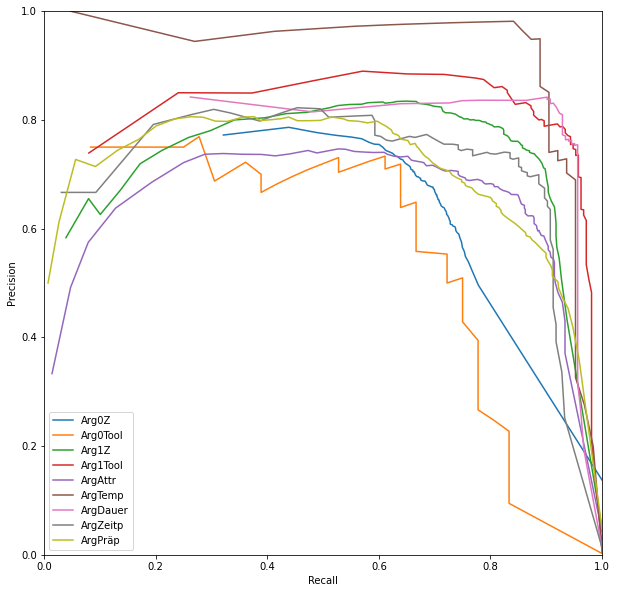

In [65]:
plot_pr_all(thresholds,labels)

In [66]:
# Plot f score over threshold to find the best th
def plot_f_curve(df,thresholds,label):
    f = df["f"]
    # plot the roc curve for the model
    plt.plot(thresholds, f, label=label)
    # axis labels

def plot_f_all(thresholds,labels):
    plt.figure(figsize=(10,10))
    for label in labels:
        df_prf_th = prf_th(examples,thresholds,label)
        plot_f_curve(df_prf_th,thresholds,label)
    plt.xlabel('Threshold')
    plt.ylabel('f-score')
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    plt.show()

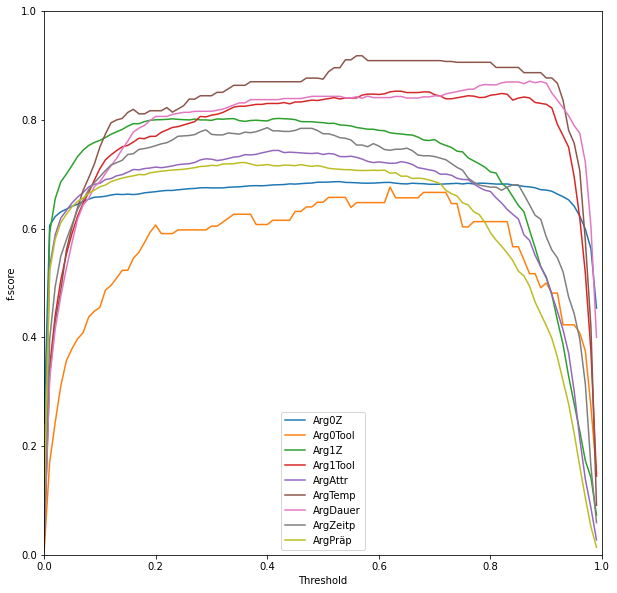

In [67]:
plot_f_all(thresholds,labels)

In [ ]:
# Unter allen falsch klassifizierten Zutaten. als was wurden diese predicted?

In [6]:
# ner.evaluate(examples)
from spacy.scorer import Scorer
scorer = Scorer()
scorer.score(examples)

{'token_acc': 0.9999238211320179,
 'token_p': 0.9998476538695917,
 'token_r': 0.9996953541507997,
 'token_f': 0.9997714982100692,
 'sents_p': 0.0,
 'sents_r': 0.0,
 'sents_f': 0.0,
 'tag_acc': 0.9998476538695916,
 'pos_acc': 0.9998476538695916,
 'morph_acc': 0.9998476538695916,
 'morph_per_feat': {},
 'dep_uas': 0.9997714982100692,
 'dep_las': 0.9997714982100692,
 'dep_las_per_type': {'': {'p': 1.0,
   'r': 0.9996953541507997,
   'f': 0.9998476538695916}},
 'ents_p': 0.9834571235651587,
 'ents_r': 0.9866215071972905,
 'ents_f': 0.9850367740299265,
 'ents_per_type': {'Z': {'p': 0.9863013698630136,
   'r': 0.9853015712113533,
   'f': 0.9858012170385396},
  'V': {'p': 0.9935691318327974,
   'r': 0.9967741935483871,
   'f': 0.9951690821256038},
  'ATTR': {'p': 0.9572519083969465, 'r': 0.9796875, 'f': 0.9683397683397682},
  'PRÄP': {'p': 0.9835616438356164,
   'r': 0.9862637362637363,
   'f': 0.9849108367626888},
  'DAUER': {'p': 0.9631578947368421, 'r': 0.953125, 'f': 0.9581151832460733},
